# Morphology Classification using a Convolutional Neural Network

Tutorial 1a -- Virtual AAS 237 Machine Learning Workshop, January 2021

This notebook contains the code we use to perform a morphological classification of a subset of CANDELS GOODS-S galaxies. Kartaltepe et al. (2015, https://ui.adsabs.harvard.edu/abs/2015ApJS..221...11K/abstract) describes the sample, and the visual classification scheme employed on the parent sample in detail. We make use of this parent sample to derive a subset mainly consisting of two morphology types, spheroids and disks, selected via the following prescription:

if ['f_Dk_'] > 0.90 & ['f_Sph_'] < 0.30 --> Morphology = Disk, class_label = 1

if ['f_Sph_'] > 0.90 & ['f_Dk_'] < 0.30 --> Morphology = Spheroid, class_label = 0

where f_Dk_ and f_Sph_ is the fraction of classifiers that designated that a given galaxy has a disk or spheroid morphology, respectively. The goal of this tutorial is to determine whether a convolutional neural network model could be capable of performing high accuracy classification of these two classes. Note that the data selection from the CANDELS catalog has already been performed, and in this notebook we only read in pickle files that contain this subset.

Note: Please also see the presentation accompanying this notebook for some extra details.

Contact: Sinan Deger, sdeger@ipac.caltech.edu



In [1]:
import os
import time
import sys
print(sys.path)
print(sys.executable)
import random
"""Import the basics: numpy, pandas, matplotlib, etc."""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
"""Import keras and other ML tools"""
import tensorflow as tf
import keras
print("keras version:", keras.__version__)
print("tensorflow version:", tf.__version__)
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers.core import Dropout, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
"""Import scikit learn tools"""
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
"""Import astropy libraries"""
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

['/home/mlworkshop_usr/Tutorial_1/notebooks', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python37.zip', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/lib-dynload', '', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages', '/home/mlworkshop_usr/anaconda3/envs/T1P3/lib/python3.7/site-packages/IPython/extensions', '/home/mlworkshop_usr/.ipython']
/home/mlworkshop_usr/anaconda3/envs/T1P3/bin/python


Using TensorFlow backend.


keras version: 2.3.1
tensorflow version: 2.0.0-rc0


# Data Exploration

First, we read in the pickle files generated according to the selection criteria we have presented above. 'f160w_images_unique.pickle' contains the images themselves, and 'f160w_labels_unique.pickle' contains their corresponding labels where (spheroid = 0) and (disk = 1). We begin by displaying some simple information about the data, e.g. how many galaxies there are of each type. Next, we display some example postage stamps. Each cutout is 41x41 pixels in size. This is also the image size we will feed into the convolutional neural network. We first display some example disk galaxies, followed by spheroids.


Number of images:  2120
Number of objects classified as disk in the total sample:  1693
Number of objects classified as spheroid in the total:  427
Fraction of spheroid galaxies: 0.201
Example Disk Galaxies: 


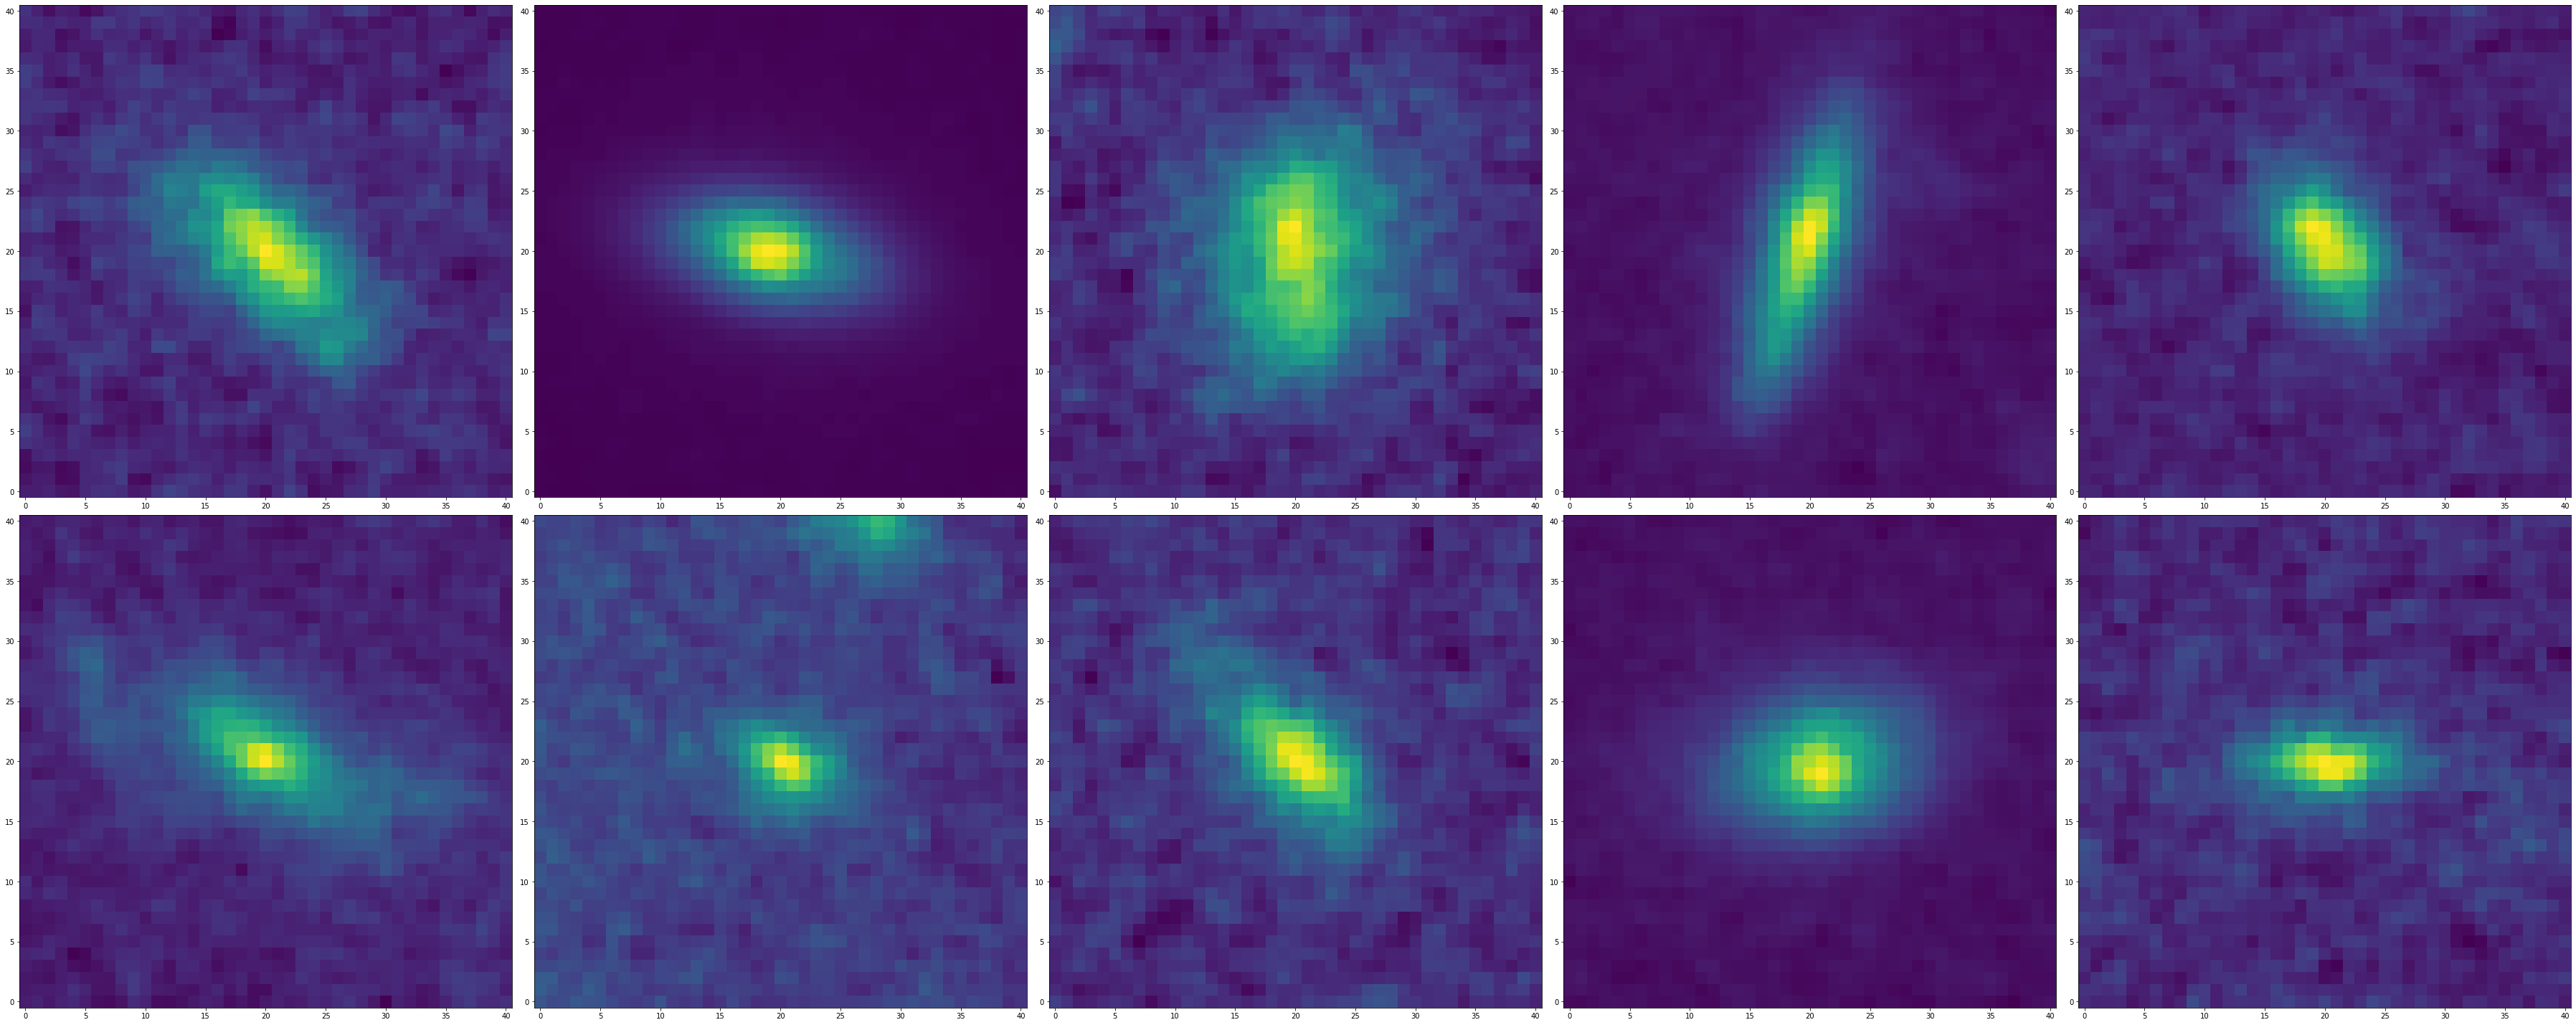

Example Spheroid Galaxies: 


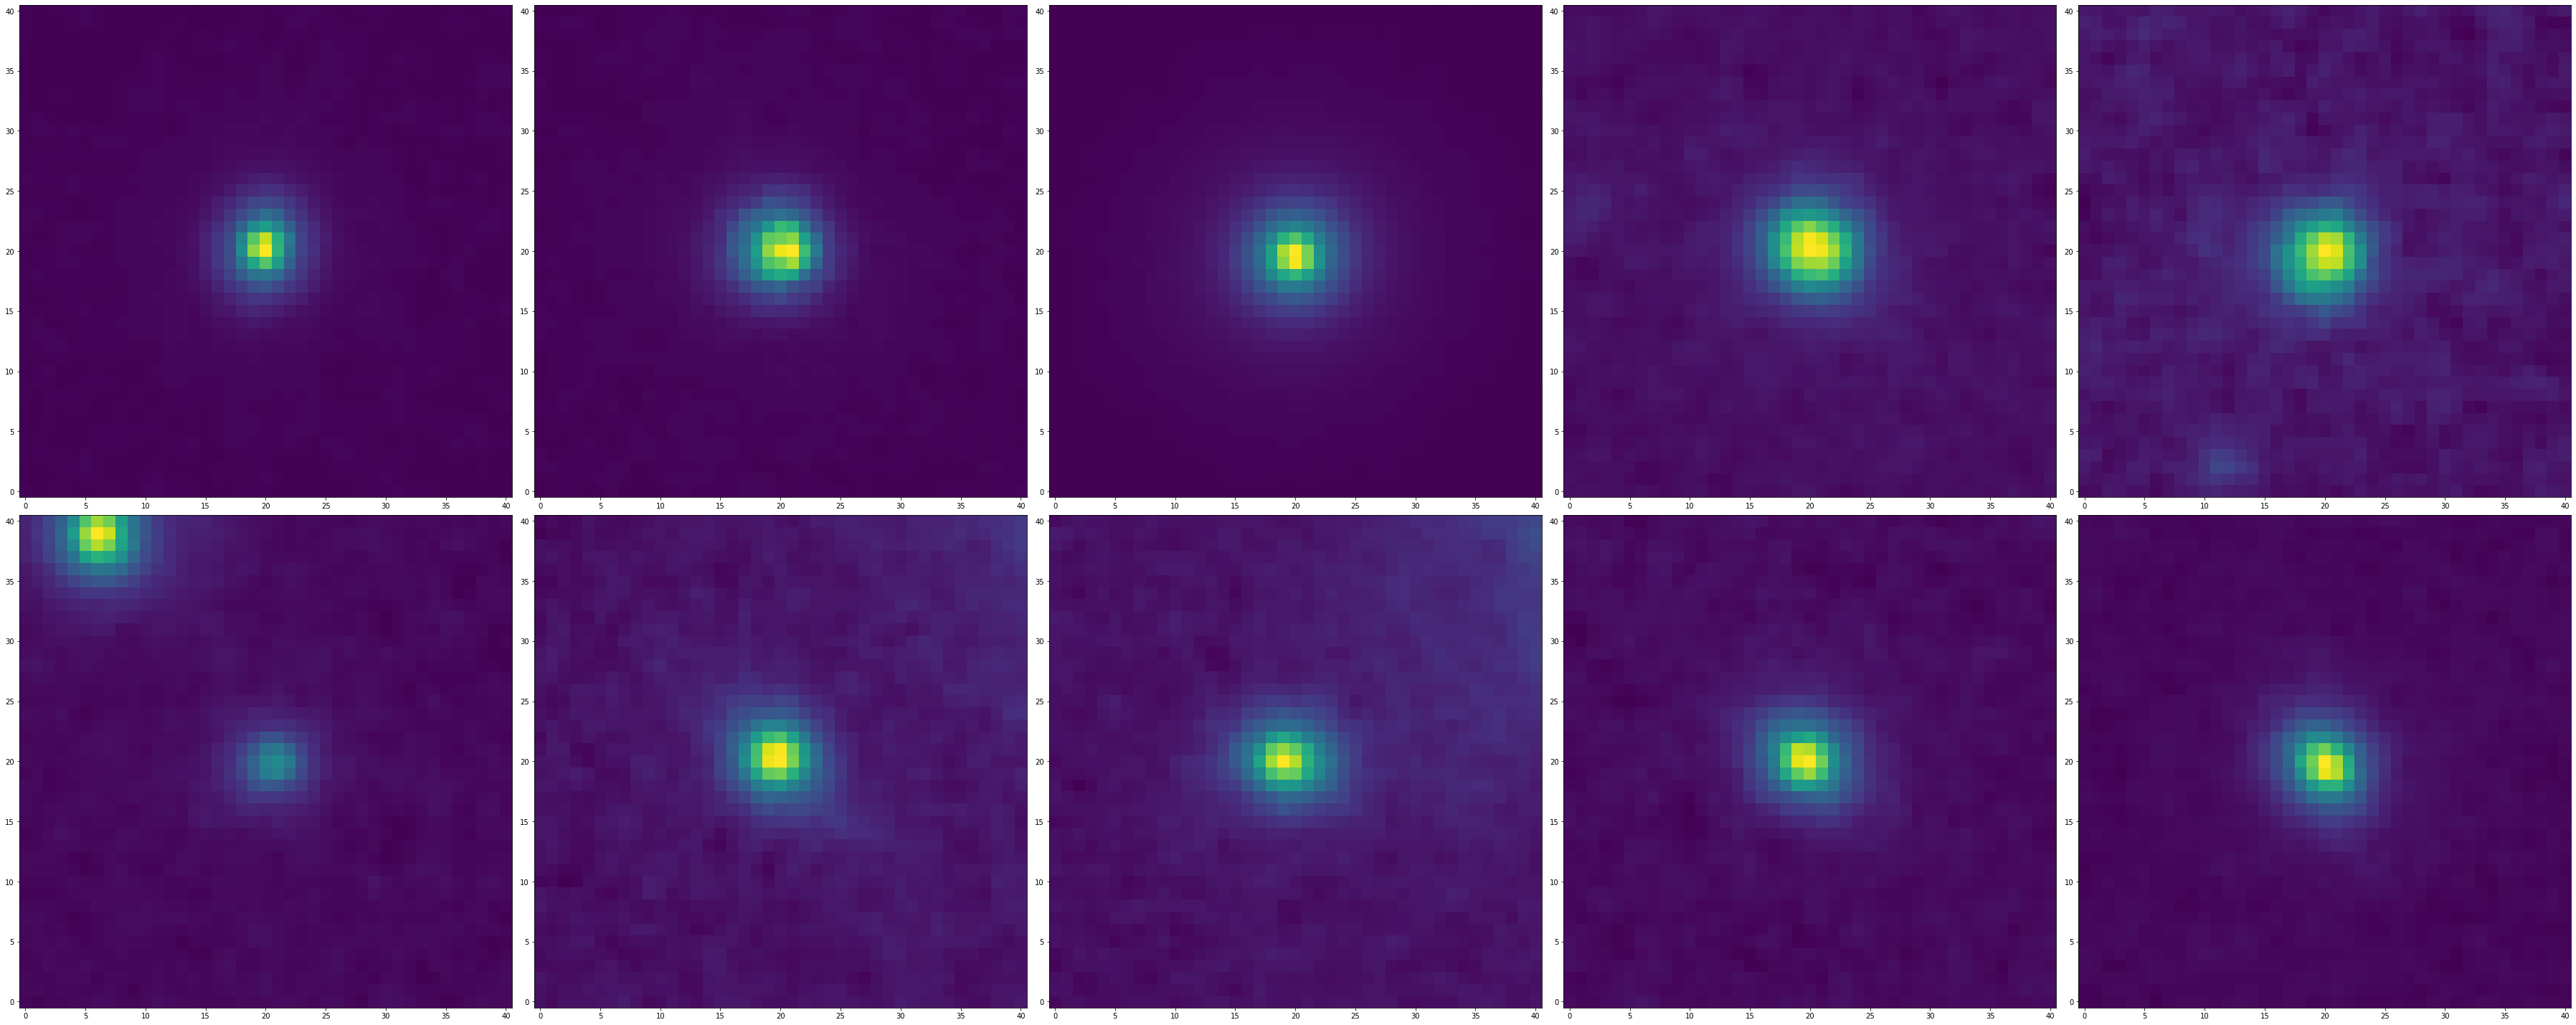

In [2]:
"""
Load the data files. f160w_images.pickle contains the image data,
and f160w_labels.pickle contains their corresponding handles.
"""

with open('../data/f160w_images_unique.pickle', 'rb') as x:
    img_data = pickle.load(x)

with open('../data/f160w_labels_unique.pickle', 'rb') as y:
    img_labels = pickle.load(y)
    
"""Print data stats following the selection from the parent sample"""

print('Number of images: ', img_labels.shape[0])
print('Number of objects classified as disk in the total sample: ', np.count_nonzero(img_labels == 1))
print('Number of objects classified as spheroid in the total: ', np.count_nonzero(img_labels == 0))
print('Fraction of spheroid galaxies:', round(np.count_nonzero(img_labels == 0)/img_labels.shape[0], 3))

"""
Make postage stamps of random disk and spheroid galaxies. Seed specified below to maintain reproducibility.
"""

np.random.seed(42)

disk_list = np.where(img_labels == 1)
random_disk_galaxies = np.random.choice(np.shape(disk_list)[1], size=10, replace=False)

print('Example Disk Galaxies: ')

fig = plt.figure(figsize=(50, 20))

for img_disk in range(len(random_disk_galaxies)):
    
    ax = fig.add_subplot(2, 5, img_disk+1)
    ax.imshow(img_data[disk_list[0][random_disk_galaxies[img_disk]]], origin='lower')
    
plt.tight_layout()
plt.show()
plt.close()

print('Example Spheroid Galaxies: ')

sph_list = np.where(img_labels == 0)
random_sph_galaxies = np.random.choice(np.shape(sph_list)[1], size=10, replace=False)

fig = plt.figure(figsize=(50,20))

for img_sph in range(len(random_sph_galaxies)):
    
    ax = fig.add_subplot(2, 5, img_sph+1)
    ax.imshow(img_data[sph_list[0][random_sph_galaxies[img_sph]]], origin='lower')

plt.tight_layout()
plt.show()
plt.close()

"""Convert labels to categorical"""

img_data = np.expand_dims(img_data, axis=3)
img_labels = to_categorical(img_labels, num_classes=2)

# Training and Test/Validation Samples

In this part we will split our sample into two; one sample that we will use to train the neural network, aptly named the training sample, and another sample called the test sample. The network will not see the test sample itself during training, but we will use the trained neural network to predict its labels. It will therefore serve as validation to the accuracy of the neural network that has been trained using a different subset of images. We chose to set the size of the test sample as 15% of the total sample, as it is common practice to choose a test sample smaller in size compared to the training sample. It is important to make this split by roughly preserving the ratio of the labels within the total sample. Random splits may cause one of the labels to be underrepresented within training sample, thereby resulting in a neural network inacapable of accurate classifications as it is undertrained in one of the labels. We perform a stratified sampling below to preserve the original ratios of the two morphology types when making the split. 

In [3]:
"""
Use stratification to split the data into training & test samples.
This preserves the ratio of class 0 to class 1 objects when we split the
total sample into training and test samples. We choose the test sample to be 15%
of the total sample size.
"""

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
print(skf)
skf.split(img_data, img_labels)


for train_index, test_index in skf.split(img_data, img_labels):
    
    X_train, X_test = img_data[train_index], img_data[test_index]
    y_train, y_test = img_labels[train_index], img_labels[test_index]

    
print('Number of images in the training sample: ', X_train.shape[0])
print('Number of objects classified as disk in the training sample: ',
      len(np.unique(np.where(y_train == [0, 1])[0])))
print('Number of objects classified as spheroid in the training sample: ',
      len(np.unique(np.where(y_train == [1, 0])[0])))
print('Fraction of spheroid objects in the training sample',
      round((np.count_nonzero(y_train == [1, 0])/2)/X_train.shape[0], 3))


StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.15,
            train_size=None)
Number of images in the training sample:  1802
Number of objects classified as disk in the training sample:  1439
Number of objects classified as spheroid in the training sample:  363
Fraction of spheroid objects in the training sample 0.201


# The Neural Network Model

Below we define the neural network model we use for this task. This is a particularly and deliberately simple model. It consists only of convolution blocks (see introductory presentation), dropout layers, and dense layers as the final layers of the network to produce predictions. Dropout randomly ignores nodes within the network, in an effort to prevent overfitting. It becomes especially useful in small training samples, or inhomogeneous ones such as this case.  

In [4]:
"""The convolutional neural network model"""

def convnet_model(input_shape, training_labels, dropout_rate=0.15):

    unique_labs = len(np.unique(training_labels))

    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(unique_labs, activation='softmax'))

    return model

# Fitting the Neural Network Model

Here we train the neural network model defined above. The training session will output loss, and accuracy at each epoch. We also plot the progression of the loss and accuracy with respect to training epochs after the training is completed.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 41, 41, 16)        160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 41, 41, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 32)        4640      
_________________________________________________________________
dropout_2 (Dropout)          (None, 41, 41, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 41, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 107584)           

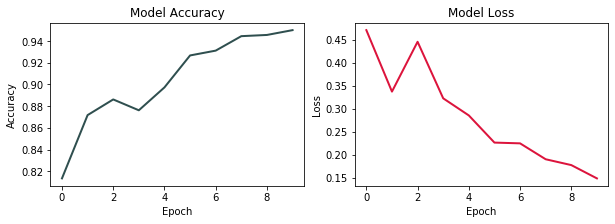

In [5]:
"""Train the neural network model"""

cn_model = convnet_model(X_train.shape[1:], y_train)
cn_model.summary()

cn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=["accuracy"])

"""
Define the callbacks to be used during the training.
checkpointer: outputs the latest iteration of the model. 
early_stopper: terminates the training if the loss doesn't improve in the number of
               turns set via the keyword "patience".
"""

checkpointer = ModelCheckpoint('keras_convnet_model.h5', verbose=1)
early_stopper = EarlyStopping(monitor='loss', patience=2, verbose=1)

start = time.time()

#classifier = cn_model.fit(X_train, y_train, epochs=10, batch_size=128, callbacks=[checkpointer, early_stopper])
classifier = cn_model.fit(X_train, y_train, epochs=10, batch_size=128, callbacks=[early_stopper])

end = time.time()
print('Process completed in', round(end-start, 2), ' seconds')

"""
Plot accuracy/loss versus epoch
"""

fig = plt.figure(figsize=(10,3))

ax1 = plt.subplot(121)
ax1.plot(classifier.history['accuracy'], color='darkslategray', linewidth=2)
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2 = plt.subplot(122)
ax2.plot(classifier.history['loss'], color='crimson', linewidth=2)
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

plt.show()
plt.close()

# Validation

Finally, we use the model trained above to make predictions on the test/validation sample. We then compare these predicted labels with the original ones, and derive a prediction accuracy. 

318/318 [==============================] - 1s 2ms/step
Fraction of correct predictions:  0.92


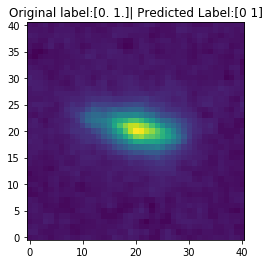

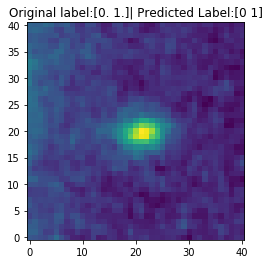

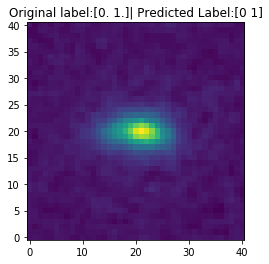

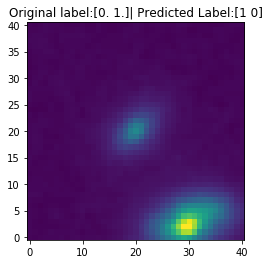

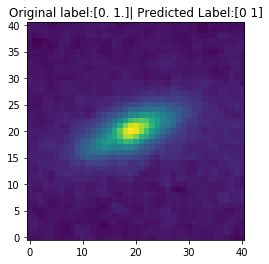

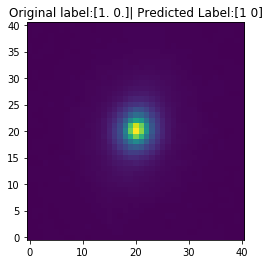

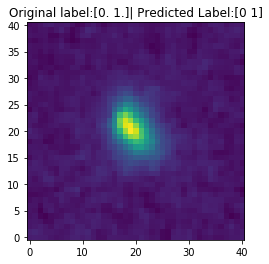

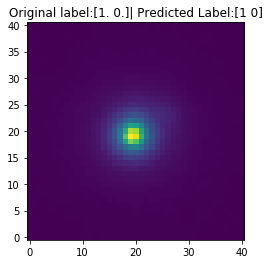

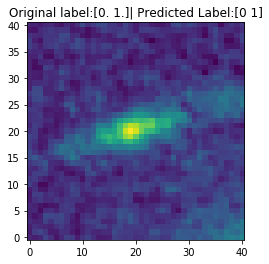

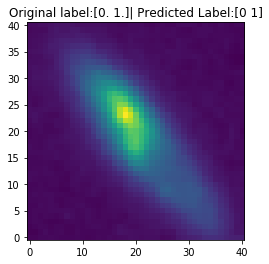

In [6]:
preds_test = cn_model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

X_test_plot = np.squeeze(X_test, axis=3)

print('Fraction of correct predictions: ', round(accuracy_score(y_test, preds_test_t), 2))

"""Uncomment to see postage stamps with predictions from the test sample"""

for w in range(10):
    plt.imshow(X_test_plot[w], origin='lower')
    plt.title('Original label:' + str(y_test[w]) + '| Predicted Label:' + str(preds_test_t[w]))
    plt.show()
